## Calculation of the global R_eff numbers
## Objective
To be able to understand and later foresee government decisions on lockdown measures, we need to look at the same metrics as governments do. Among others as active cases or intensive care units, this is also the (effective) reproduction number.


## Data Sources
### Patients Linelist
Global linelist from beoutbreakprepared <https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz> with data catalogue here <https://www.nature.com/articles/s41597-020-0448-0> 

The data is a tar.gz (Status 2020-07-20)
### Casenumbers
Johns Hopkins global casenumbers <https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/>.


## Calculation Procedure
The calculation of R_eff consists of multiple calculation
### Create a linelist
In the global linelist from beoutbreakprepared, there are not all cases listed, so in order to impute symptoms onset dates for the missing datapoints, we need a list, which inherits these gaps. This list can be created from a linelist from Johns Hopkins Data, sa here are all cases listed and substract the patients linelist for the specific country from beoutbreakprepared.
### Imputation
At first the datapoints with missing symptoms-onset date are imputed. Therefor for all datapoints for which we have the reporting and the symptoms onset date the reporting delay is calculated. Then a Weibull distribution is fitted for the reporting delay. This distribution is then applied to the datapoints with missing symptoms onset date for assigning a certain reporting delay to these datapoints and calculate the symptons onset date.
### Nowcasting
The same distribution is then used to adapt the casenumbers to account for possible cases which will be reported in the future with symptoms onset date until today.
### Rolling Window Ratio
The calculation of r_eff itself is performed as a summation of casenumbers within a certain timeperiod. We use 4 days (according to RKI for Germany). Then the ratio of two sums is compared. Here we also compare the sums with 4 days inbetween (according to RKI for Germany).
### Validation
The calculation procedure was validated for Germany and compared with the official published numbers from RKI for nowcasted and r_eff values.
<<https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.html>>

Code toggling

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [1]:
!ls -la /project_data/data_asset/venus/r_eff_numbers_globally/

total 100
drwxr-x---. 3 wsuser watsonstudio 8192 Jul 15 08:40 .
drwxr-x---. 6 wsuser watsonstudio 4096 Jul 17 06:20 ..
-rw-r-----. 1 wsuser watsonstudio 3550 Jul 20 21:30 imputedBelgiumglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3694 Jul 20 21:37 imputedFranceglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3622 Jul 15 09:05 imputedItalyglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3515 Jul 15 08:21 imputedKorea, Republic ofglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3570 Jul 14 15:33 imputedUnited Kingdomglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3550 Jul 20 21:30 nowcastBelgiumglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3723 Jul 20 21:37 nowcastFranceglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3670 Jul 15 09:05 nowcastItalyglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3515 Jul 15 08:21 nowcastKorea, Republic ofglobal_delay_distr.csv
-rw-r-----. 1 wsuser watsonstudio 3570 Jul 14 15:33 nowca

Imports

In [2]:
import pandas as pd
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min 
from datetime import date 
import ipywidgets as widgets
import difflib
import random
from itertools import repeat

hide_toggle()

Data Import

Global patients linelist

In [4]:
patients=pd.read_csv("/project_data/data_asset/latestdata_20200720.csv",
                                             parse_dates=False,
    usecols=[
        'country',
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

hide_toggle()

Enrich the global linelist data with countrycode to match the global casenumbers

In [5]:
dfMapping=pd.read_csv("/project_data/data_asset/country_name_mapping.csv")
for country in patients.country.unique():
    try:
        ADM0_A3 = dfMapping[dfMapping.name == country].ADM0_A3.values[0]
        patients.loc[patients["country"]==country,"ADM0_A3"]=ADM0_A3
    except:
        pass

hide_toggle()

1. Datetime Formatting
2. Filter the global linelist for all rows, which have both: reporting and symptoms onset date

In [6]:
patients.date_confirmation=pd.to_datetime(patients.date_confirmation,format="%d.%m.%Y",errors="coerce")
patients.date_onset_symptoms=pd.to_datetime(patients.date_onset_symptoms,format="%d.%m.%Y",errors="coerce")
patients=patients.dropna(axis=0,how="any")

hide_toggle()

In [7]:
# save the patients linelist to a parquet file for faster processing in the next run:
patients.to_parquet("/project_data/data_asset/venus/patients_line_list.parquet")

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


### Import linelist!

In [31]:
patients=pd.read_parquet("/project_data/data_asset/venus/patients_line_list.parquet")

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [8]:
patients.head(5)

,country,date_onset_symptoms,date_confirmation,ADM0_A3
53,China,2020-02-08,2020-02-14,CHN
55,China,2020-02-01,2020-02-13,CHN
335,Singapore,2020-01-30,2020-02-14,SGP
365,Japan,2020-02-14,2020-02-16,JPN
446,Singapore,2020-02-11,2020-02-15,SGP


Global casenumbers

In [9]:
df_cssegi=pd.read_csv("/project_data/data_asset/mercury/casenumbers/johns_hopkins_casenumbers_all_countries.csv")

hide_toggle()

Just use the countrycodes which are present in both datasets

In [10]:
list1=list(patients.ADM0_A3.unique())
list2=list(df_cssegi.ADM0_A3.unique())

country_codes=list(set(list1).intersection(list2))
print("global linelist no countries: ", len(list1), "Johns hopkins casenumbers no countries: ", len(list2), "", len(country_codes))

hide_toggle()

global linelist no countries:  48 Johns hopkins casenumbers no countries:  186  48


Routine for creating a multiple options clickbox

In [11]:
# Routine for multicheckbox from github

def multi_checkbox_widget(descriptions):
    """ Widget with a search field and lots of checkboxes """
    search_widget = widgets.Text()
    options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
    options = [options_dict[description] for description in descriptions]
    options_widget = widgets.VBox(options, layout={'overflow': 'scroll'})
    multi_select = widgets.VBox([search_widget, options_widget])

    # Wire the search field to the checkboxes
    def on_text_change(change):
        search_input = change['new']
        if search_input == '':
            # Reset search field
            new_options = [options_dict[description] for description in descriptions]
        else:
            # Filter by search field using difflib.
            close_matches = difflib.get_close_matches(search_input, descriptions, cutoff=0.0)
            new_options = [options_dict[description] for description in close_matches]
        options_widget.children = new_options

    search_widget.observe(on_text_change, names='value')
    return multi_select

hide_toggle()

Routine for padding the timeseries

In [12]:
# Routine for padding the timeseries

idx = pd.IndexSlice

date_index=pd.date_range(start='01/01/2020',end=date.today(),freq='D')

def filldates(df):
    df.reset_index(drop=True,inplace=True)
    df=df.asfreq("1D",fill_value=0.0).reindex(date_index,fill_value=0.0)
    return df

hide_toggle()

Routine to create a linelist from the Johns Hopkins Data 
Also integrate the dates with symptoms onset date from the patients data, if available

In [13]:
# Routine to create a linelist from the Johns Hopkins Data 

#l = []
#l.extend(repeat(x, 100))
def create_linelist(df_cssegi,df_patients_onset):
    HELP=[]
    #HELP2=[]
    for index,row in df_cssegi.iterrows():
        HELP.extend(repeat(row["date"],row["confirmed"]))

    HELP=pd.to_datetime(HELP)
    #HELP2=pd.to_datetime(HELP2)
    df_linelist=pd.DataFrame(columns=["ReportingDate","SymptomsOnsetDate"],data=list(zip(HELP,HELP)))

    # list with only valid dates, delay > 0 days 
    # use the patients linelist for this
    df_linelist_clean=pd.DataFrame({"ReportingDate":pd.to_datetime(df_patients_onset["date_confirmation"]),
                                    "SymptomsOnsetDate":pd.to_datetime(df_patients_onset["date_onset_symptoms"])})
    
    # Include the delay of 0 days for cases where we do not have the symptoms onset date.
    df_linelist.loc[:,"delay"]=df_linelist["ReportingDate"]-df_linelist["SymptomsOnsetDate"]

    # just for the cases where we do have both dates
    df_linelist_clean.loc[:,"delay"]=df_linelist_clean["ReportingDate"]-df_linelist_clean["SymptomsOnsetDate"]
    
    # Now integrate the linelist_clean dates into the other linelist
    # This is quite timeconsuming!
    #for i in df_linelist_clean.itertuples():
    #    for j in df_linelist.itertuples():
    #        if ((i[1]==j[1])&(j[3].days==0)):
    #            df_linelist.loc[j[0],"SymptomsOnsetDate"]=i[2]
    #            df_linelist.loc[j[0],"delay"]=i[3]
    #            break
      
    
    for i in df_linelist_clean.itertuples():
        idx=((df_linelist["ReportingDate"]==i[1])&(df_linelist["SymptomsOnsetDate"]==i[1])).idxmax
        df_linelist.loc[idx,"SymptomsOnsetDate"]=i[2]
        df_linelist.loc[idx,"delay"]=i[3]
    
    return df_linelist, df_linelist_clean

hide_toggle()

Routine for performing the imputation

In [14]:
# Routine for performing the imputation 
# Fitting Weibull Distribution
def imputation(df_linelist,df_linelist_clean,name):
    shape, loc, scale = weibull_min.fit(df_linelist_clean["delay"].dt.days, floc=0)
    wb_row=[name,shape,loc,scale]
    
# distribute missing values accordingly to that distribution:
# create random numbers and assign to the missing delay values in the dataframe:
# overall values
    size=len(df_linelist)
    r=weibull_min.rvs(shape,loc=loc,scale=scale,size=size)
    df_linelist.loc[:,"delay_weibull"]=[datetime.timedelta(days=int(i)) for i in r]
    df_linelist.loc[:,"SymptomsOnsetDate Weibull"]=df_linelist["ReportingDate"]-df_linelist["delay_weibull"]
    #print(np.mean(df_linelist["delay_weibull"]))

# combine the known values with the imputated values:
    df_linelist.loc[df_linelist["delay"].dt.days<=0,"Combined"]=df_linelist.loc[df_linelist["delay"].dt.days<=0,"SymptomsOnsetDate Weibull"]
    df_linelist.loc[df_linelist["delay"].dt.days>0,"Combined"]=df_linelist.loc[df_linelist["delay"].dt.days>0,"SymptomsOnsetDate"]

    onset_combined=df_linelist["Combined"].value_counts()
    
# padding the timeseries data to get an entry for every day
    onset_combined.sort_index(inplace=True)
    onset_combined=onset_combined.asfreq("1D",fill_value=0.0).reindex(date_index,fill_value=0.0)
    
    number=max(df_linelist["delay"].dt.days)
    
# calculate p_delay for nowcasting routine
    p_delay=pd.Series(data=weibull_min.pdf(np.arange(0,number),shape,loc=loc,scale=scale),index=np.arange(0,number))
  
    return onset_combined,p_delay,wb_row

hide_toggle()

Creating a global linelist delay distribution

In [15]:
# Creating the global linelist delay distribution
df_linelist_clean_global=patients
print("Globally we have ",len(df_linelist_clean_global)," cases available with symptoms onset date.")
df_linelist_clean_global.loc[:,"delay"]=df_linelist_clean_global["date_confirmation"]-df_linelist_clean_global["date_onset_symptoms"]
# fitting a Weibull distribution to the global delay
shape_global, loc_global, scale_global = weibull_min.fit(df_linelist_clean_global["delay"].dt.days, floc=0)

Globally we have  261335  cases available with symptoms onset date.


Plot the global delay distribution and the fitted Weibull curve:

Text(0.5, 1.0, 'Histogram and fitted Weibull distribution for the global reporting delay')

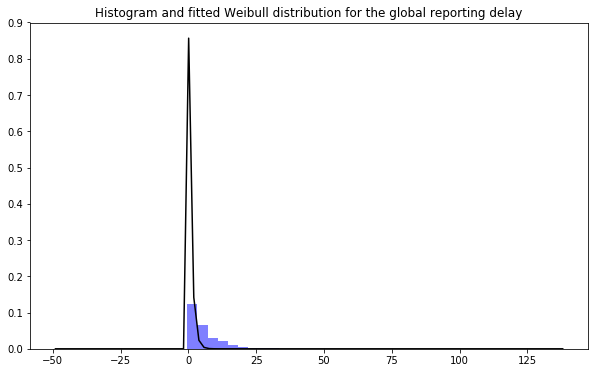

In [16]:
plt.figure(figsize=(10,6))
plt.hist(df_linelist_clean_global["delay"].dt.days, density=True, alpha=0.5,bins=50,color="blue")
x = np.linspace(df_linelist_clean_global["delay"].dt.days.min(), df_linelist_clean_global["delay"].dt.days.max(), 100) 
plt.plot(x, weibull_min(shape_global, loc=loc_global, scale=scale_global).pdf(x),color="black") 
plt.title("Histogram and fitted Weibull distribution for the global reporting delay")

Routine for performing the imputation based on the global delay distribution

In [17]:
def imputation_global(df_linelist,df_linelist_clean,name):
# distribute missing values accordingly to that distribution:
# create random numbers and assign to the missing delay values in the dataframe:
# overall values
    size=len(df_linelist)
    r=weibull_min.rvs(shape_global,loc=loc_global,scale=scale_global,size=size)
    wb_row=[name,shape_global,loc_global,scale_global]
        
    df_linelist.loc[:,"delay_weibull"]=[datetime.timedelta(days=int(i)) for i in r]
    df_linelist.loc[:,"SymptomsOnsetDate Weibull"]=df_linelist["ReportingDate"]-df_linelist["delay_weibull"]
    
    # combine the known values with the imputated values:
    df_linelist.loc[df_linelist["delay"].dt.days<=0,"Combined"]=df_linelist.loc[df_linelist["delay"].dt.days<=0,"SymptomsOnsetDate Weibull"]
    df_linelist.loc[df_linelist["delay"].dt.days>0,"Combined"]=df_linelist.loc[df_linelist["delay"].dt.days>0,"SymptomsOnsetDate"]

    onset_combined=df_linelist["Combined"].value_counts()
    
# padding the timeseries data to get an entry for every day
    onset_combined.sort_index(inplace=True)
    onset_combined=onset_combined.asfreq("1D",fill_value=0.0).reindex(date_index,fill_value=0.0)
    
    number=max(df_linelist["delay"].dt.days)
    
# calculate p_delay for nowcasting routine
    p_delay=pd.Series(data=weibull_min.pdf(np.arange(0,number),shape_global,loc=loc_global,scale=scale_global),index=np.arange(0,number))
    
    return onset_combined, p_delay, wb_row

hide_toggle()    

Nowcasting Routine from rt.live

In [18]:
# Nowcasting Routine from rt.live

def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        mode="constant",
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay

hide_toggle()

Which timewindow to use for the r_eff calculation? (RKI uses 4 days)

In [19]:
# set the timewindow for sliding window
# RKI uses 4 days:
window=widgets.IntSlider(
    value=4,
    min=0,
    max=10,
    step=1,
    description='Sliding time window',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(window)

#hide_toggle()

IntSlider(value=4, continuous_update=False, description='Sliding time window', max=10)

Routine for performing the r_eff calculation

In [20]:
# Routine for performing the r_eff calculation
def calculate_reff(onset_adjusted):
    df_rolling=onset_adjusted.rolling(window.value).sum()
    r_t=df_rolling.pct_change(periods=window.value)+1.0
    r_t.sort_index(inplace=True)
    return r_t

hide_toggle()

Grouping the overall casenumbers dataframe

In [21]:
grouped_cssegi=df_cssegi.groupby("ADM0_A3")

hide_toggle()

In [22]:
import pickle
def save_obj(obj, name):
    with open('/project_data/data_asset/venus/r_eff_numbers_globally/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/project_data/data_asset/venus/r_eff_numbers_globally/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
hide_toggle()

## Perform the calculation for all available countries and save the results to dataframes
### Perform the calculation (Imputation, Nowcasting, r_eff)
If there are no cases with symptoms onset data for a specific country or if the percentage of cases with symptoms onset date is below a certain threshold (10%?) we will use a global delay distribution, which is calculated from all given symptoms onset dates. That is very bad approximation, but is used as a start. (This is also the approach used by rt.live
For each country a linelist is created from Johns Hopkins numbers and then combined with the patients linelist from beoutbreakprepared.

In [48]:
# do the complete calculation for all countries:

max_count=len(country_codes)
progress=widgets.IntProgress(min=0,max=max_count)
#display(progress)

data=[]
imputed=pd.DataFrame(index=date_index)
nowcast=pd.DataFrame(index=date_index)
r_eff=pd.DataFrame(index=date_index)

#for code in country_codes:
for code in ["ITA"]:
    print("code = ",code)
    name=dfMapping[dfMapping["ADM0_A3"]==code].name.values[0]
    print("name = ",name)   
    # get cssegi data
    df=grouped_cssegi.get_group(code)
    
    # get patients data
    df_patients=patients[patients["country"]==name]
    
    # create linelist
    df_linelist,df_linelist_clean=create_linelist(df, df_patients)
    print("linelist done")
    
    # get share of data with symptoms onset date
    df.set_index("date", inplace=True)
    df.index=pd.to_datetime(df.index)
    df.sort_index(inplace=True)    
    # How big is the share of patients with symptons onset date given?
    # --> can we use the country specific delay distribution or do we use the global delay distribution?
    FLAG_GLOBAL=False
    share_symptoms=len(df_patients)/df["confirmed"][-1]*100
    if share_symptoms < 10:
        print("the global delay distribution will be used for country ", name)
        FLAG_GLOBAL=True
                   
    # perform imputation
    # Call the routine for imputing the missing dates Depending on the flag FLAG_GLOBAL, we either use the delay distribution of the specific country or use the global distribution.
    if FLAG_GLOBAL==False:
        onset_combined,p_delay,wb_row=imputation(df_linelist,df_linelist_clean,name)  
    elif FLAG_GLOBAL==True:
        onset_combined,p_delay,wb_row=imputation_global(df_linelist,df_linelist_clean,name) 
    else:
        print("s.th. went wrong, the FLAG_GLOBAL was not set.")
    print("imputation done")
    
    # perform nowcasting
    onset_adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset_combined, p_delay)
    print("nowcasting done")
    
    # calculate r_t
    r_t=calculate_reff(onset_adjusted)
    print("r_t done")

    # convert the Series data into Dataframes and save them for each country as csv
    imputed=pd.DataFrame(index=onset_combined.index,data=list(onset_combined),columns=["imputed"])
    nowcast=pd.DataFrame(index=onset_adjusted.index,data=list(onset_adjusted),columns=["nowcast"])
    r_eff=pd.DataFrame(index=r_t.index,data=list(r_t),columns=["r_eff"])
    
    # put the information into the file if a country specific or the global delay distribution was used
    if FLAG_GLOBAL==False:
        flag_global=""
    elif FLAG_GLOBAL==True:
        flag_global="global_delay_distr"
    
    imputed.to_csv("/project_data/data_asset/venus/r_eff_numbers_globally/imputed"+name+flag_global+".csv",index_label=False)
    nowcast.to_csv("/project_data/data_asset/venus/r_eff_numbers_globally/nowcast"+name+flag_global+".csv",index_label=False)
    r_eff.to_csv("/project_data/data_asset/venus/r_eff_numbers_globally/r_eff"+name+flag_global+".csv",index_label=False)
    
    # add the dataframes to an "all data" array and save that one in the end.
    #
    
    wb_row.append(FLAG_GLOBAL)
    data.append(wb_row)
                   
    progress.value+=1
    
# save the curve parameters to a dataframe    
df_wb=pd.DataFrame(columns=["country","shape","loc","scale","flag_global"],data=data)
df_wb=df_wb.set_index("country")

hide_toggle()

code =  ITA
name =  Italy
linelist done
the global delay distribution will be used for country  Italy
imputation done
nowcasting done
r_t done
code =  GER


IndexError: index 0 is out of bounds for axis 0 with size 0

Save the "all data" array to a dataframe and then to csv or pkl.

In [ ]:
save_obj(nowcast,"nowcast")
#nowcast=load_obj("nowcast")

In [ ]:
save_obj(r_eff,"r_eff")
#r_eff=load_obj("r_eff")

In [ ]:
save_obj(df_wb,"df_wb")
#r_eff=load_obj("df_wb")

## Run only for selected countries

In [23]:
options=dfMapping[dfMapping.ADM0_A3.isin(country_codes)].name.unique()
select_plot = multi_checkbox_widget(options)

select_plot

Important: Please just select one country!

In [ ]:
# for automated job run: preselect one country
#name="Australia"

# extract the name from the selection
name = [w.description for w in select_plot.children[1].children if w.value]
print("Selected Country: ",name)
# give warning if more than one country is selected
if len(name)>1:
    print(len(name), "Please select only one country!")
# get the country_code from the country name
country_code=dfMapping[dfMapping["name"]==name[0]].ADM0_A3.values[0]
print("Selected Country Code: ",country_code)
# get the overall casenumbers for the selected country
df=grouped_cssegi.get_group(country_code)
df_raw=df.copy()
#plt.figure
df.set_index("date", inplace=True)
df.index=pd.to_datetime(df.index)
df.sort_index(inplace=True)
print("confirmed cases: ",df["confirmed"][-1])

df_patients=patients[patients["country"]==name[0]]
print("number of patients in linelist with 'symptoms onset' and 'confirmation' date: ",len(df_patients))
print("that is ",len(df_patients)/df["confirmed"][-1]*100,"% of all cases")

# Create linelist for the selected country from Johns Hopkins data and combine it with the patients data.
df_linelist,df_linelist_clean=create_linelist(df_raw, df_patients)

# How big is the share of patients with symptons onset date given?
# --> can we use the country specific delay distribution or do we use the global delay distribution?
FLAG_GLOBAL=False
share_symptoms=len(df_patients)/df["confirmed"][-1]*100
if share_symptoms < 10:
    print("the global delay distribution will be used for country ", name[0])
    FLAG_GLOBAL=True
    
# Call the routine for imputing the missing dates Depending on the flag FLAG_GLOBAL, we either use the delay distribution of the specific country or use the global distribution.
if FLAG_GLOBAL==False:
    onset_combined,p_delay,wb_row=imputation(df_linelist,df_linelist_clean,name[0])  
elif FLAG_GLOBAL==True:
    onset_combined,p_delay,wb_row=imputation_global(df_linelist,df_linelist_clean,name[0]) 
else:
    print("s.th. went wrong, the FLAG_GLOBAL was not set.")
    
# Call the routine for nowcasting
onset_adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset_combined, p_delay)
# calculate r_t
r_t=calculate_reff(onset_adjusted)

r_eff=pd.DataFrame(index=date_index)
r_eff[name[0]]=r_t

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(r_eff.index,r_eff[name[0]],label=name[0])
ax.hlines(y=1.0,xmin=min(r_eff.index),xmax=max(r_eff.index),lw=1.0)

%matplotlib inline

plt.ylim([0,4])
plt.legend()
plt.title("Reproduction number for selected country ")
    
hide_toggle() 

Selected Country:  ['Italy']
Selected Country Code:  ITA
confirmed cases:  244216
number of patients in linelist with 'symptoms onset' and 'confirmation' date:  3
that is  0.0012284207422937072 % of all cases
